# Data preparation

In [10]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

In [26]:
df = pd.read_csv("vannkraft_data.txt", delimiter="\t")
# smaller dataset for testing
#df = df[:10000]
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y1,y2,y3,y4
0,0.611936,0.212342,0.005564,0.002857,0.008434,0.003076,0.89286,0.33198,0.82123,0.04170,1.00,0.73,1.00,0.99
1,0.250514,0.859806,0.521153,0.452315,0.305317,0.102649,0.89286,0.33198,0.82123,0.04170,0.00,1.00,0.00,0.00
2,0.150166,0.464592,0.132112,0.074232,0.154669,0.136805,0.89286,0.33198,0.82123,0.04170,0.00,0.01,0.00,0.00
3,0.316524,0.876727,0.001781,0.003298,0.008910,0.002462,0.14829,0.68229,0.16349,0.64823,0.00,0.00,0.00,0.00
4,0.303801,0.807405,0.050540,0.015564,0.065408,0.028042,0.14829,0.68229,0.16349,0.64823,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150025,0.214137,0.485883,0.011010,0.003721,0.012105,0.004806,0.44514,0.59493,0.20358,0.84718,0.00,0.00,0.00,0.00
150026,0.229117,0.275545,0.555918,0.161991,0.303823,0.206748,0.44514,0.59493,0.20358,0.84718,0.41,1.00,0.89,0.99
150027,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00,1.00,1.00,0.99
150028,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00,1.00,1.00,0.99


In [27]:
# Dataset has 10 inputs and four outputs
features = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']
outputs = ['y1', 'y2', 'y3', 'y4']
X = df[features].values
y = df[outputs].values

In [28]:
# Splitting the data. 80 % for training and 20 % for testing.
split_ratio = 0.8
train_size = int(len(X) * split_ratio)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Normalizing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting to tensors, as this is expected from pytorch
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Defining train loaders with given batch sizes. This is how much data is trained at once. 
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Architecture and training

In [29]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
# Hyperparameters. Num_layers are the amount of LSTM layers in the network. Hidden_size is the amount of units within the LSTM layers.
input_size = len(features)
hidden_size = 64 
output_size = len(outputs)
learning_rate = 0.01
epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLPRegressor(input_size, hidden_size, output_size).to(device)

# Mean squared error loss function, as we are dealing with continous outputs. Adam as optimizer, a pretty common optimizer to use.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# Training loop. Given batch size is sent to the model, and a loss is calculated for each epoch with the difference between the prediction and the labels. Both training and eval is performed in this loop

train_losses = { "y1": [], "y2": [], "y3": [], "y4": [], "total": [] }
test_losses = { "y1": [], "y2": [], "y3": [], "y4": [], "total": [] }

for epoch in range(epochs):
    model.train()
    epoch_loss = np.zeros(5)
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)

        ## in this case I am computing the loss individually for each output, this is to see if some of the predictions are particularly hard
        loss_y1 = criterion(y_pred[:, 0], y_batch[:, 0])
        loss_y2 = criterion(y_pred[:, 1], y_batch[:, 1])
        loss_y3 = criterion(y_pred[:, 2], y_batch[:, 2])
        loss_y4 = criterion(y_pred[:, 3], y_batch[:, 3])
        loss_total = (loss_y1 + loss_y2 + loss_y3 + loss_y4) / 4
        
        loss_total.backward()
        optimizer.step()

        epoch_loss += np.array([loss_y1.item(), loss_y2.item(), loss_y3.item(), loss_y4.item(), loss_total.item()])
    
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses["y1"].append(avg_train_loss[0])
    train_losses["y2"].append(avg_train_loss[1])
    train_losses["y3"].append(avg_train_loss[2])
    train_losses["y4"].append(avg_train_loss[3])
    train_losses["total"].append(avg_train_loss[4])

    ## evaluating the model
    model.eval()
    epoch_loss = np.zeros(5)

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            
            loss_y1 = criterion(y_pred[:, 0], y_batch[:, 0])
            loss_y2 = criterion(y_pred[:, 1], y_batch[:, 1])
            loss_y3 = criterion(y_pred[:, 2], y_batch[:, 2])
            loss_y4 = criterion(y_pred[:, 3], y_batch[:, 3])
            loss_total = (loss_y1 + loss_y2 + loss_y3 + loss_y4) / 4

            epoch_loss += np.array([loss_y1.item(), loss_y2.item(), loss_y3.item(), loss_y4.item(), loss_total.item()])

    avg_test_loss = epoch_loss / len(test_loader)
    test_losses["y1"].append(avg_test_loss[0])
    test_losses["y2"].append(avg_test_loss[1])
    test_losses["y3"].append(avg_test_loss[2])
    test_losses["y4"].append(avg_test_loss[3])
    test_losses["total"].append(avg_test_loss[4])

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss[4]:.6f}, Test Loss: {avg_test_loss[4]:.6f}")

Epoch [1/50], Train Loss: 0.014280, Test Loss: 0.007521
Epoch [2/50], Train Loss: 0.008200, Test Loss: 0.006720
Epoch [3/50], Train Loss: 0.007252, Test Loss: 0.006163
Epoch [4/50], Train Loss: 0.006786, Test Loss: 0.009842
Epoch [5/50], Train Loss: 0.006490, Test Loss: 0.005522
Epoch [6/50], Train Loss: 0.006351, Test Loss: 0.005939
Epoch [7/50], Train Loss: 0.006176, Test Loss: 0.005344
Epoch [8/50], Train Loss: 0.006044, Test Loss: 0.006672
Epoch [9/50], Train Loss: 0.005861, Test Loss: 0.005295
Epoch [10/50], Train Loss: 0.005657, Test Loss: 0.006654
Epoch [11/50], Train Loss: 0.005530, Test Loss: 0.006249
Epoch [12/50], Train Loss: 0.005592, Test Loss: 0.005029
Epoch [13/50], Train Loss: 0.005496, Test Loss: 0.004482
Epoch [14/50], Train Loss: 0.005421, Test Loss: 0.005509
Epoch [15/50], Train Loss: 0.005444, Test Loss: 0.005540
Epoch [16/50], Train Loss: 0.005368, Test Loss: 0.004448
Epoch [17/50], Train Loss: 0.005461, Test Loss: 0.007285
Epoch [18/50], Train Loss: 0.005323, Tes

# Evaluation

In [32]:
print("Sample Predictions:")
y_pred_test = model(X_test_tensor.to(device)).cpu().detach().numpy()
for i in range(10):
    print(f"True: {y_test[i]}, Predicted: {y_pred_test[i]}")

Sample Predictions:
True: [0.6 0.  0.  0. ], Predicted: [0.2723644  0.09164717 0.2808561  0.07675955]
True: [0. 0. 0. 0.], Predicted: [-0.00484606  0.00570425  0.00428919 -0.00728577]
True: [1.   0.56 1.   0.99], Predicted: [0.9938088 0.6172037 1.0095098 0.9736813]
True: [0.   0.04 0.   0.  ], Predicted: [-0.00414973  0.04393381  0.004452   -0.00749605]
True: [0.   0.01 0.   0.  ], Predicted: [-0.00473669  0.0117087   0.00431476 -0.0073188 ]
True: [1.   0.98 1.   0.96], Predicted: [0.98747134 1.0016037  0.989408   0.9520037 ]
True: [1.   0.84 1.   0.96], Predicted: [1.0220634  0.86407787 0.991565   0.99079454]
True: [0. 0. 0. 0.], Predicted: [-0.00484606  0.00570425  0.00428919 -0.00728577]
True: [1.   0.91 1.   0.94], Predicted: [1.0277096  0.9278617  0.98608947 0.9929696 ]
True: [0.   0.33 0.   0.  ], Predicted: [ 0.00265835  0.32193455 -0.0016194  -0.02212814]


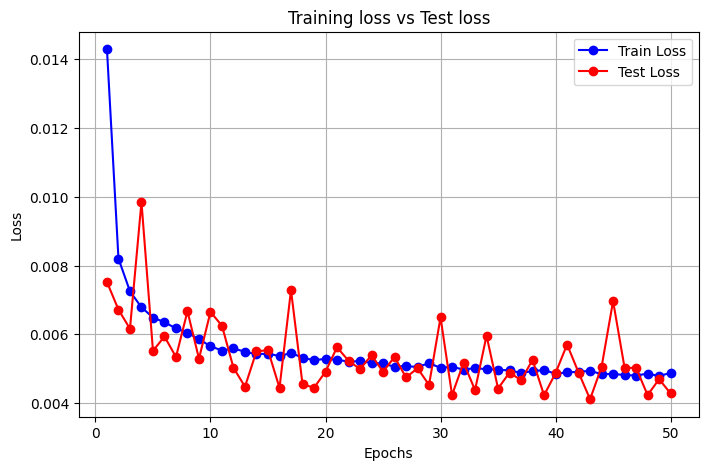

In [33]:
# Plot comparing training loss and test loss in average for the different outputs
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses["total"], label="Train Loss", marker="o", color="blue")
plt.plot(range(1, epochs+1), test_losses["total"], label="Test Loss", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss vs Test loss")
plt.legend()
plt.grid()
plt.show()

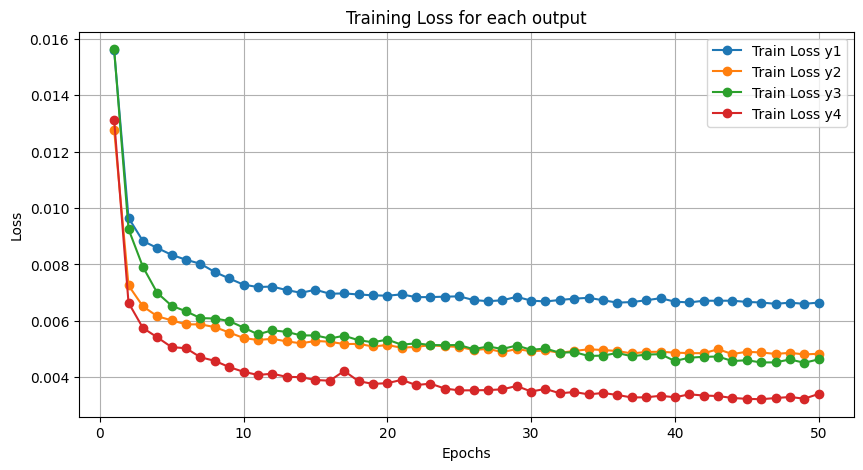

In [34]:
# Plot showing training loss for each individual output
plt.figure(figsize=(10, 5))
for key in ["y1", "y2", "y3", "y4"]:
    plt.plot(range(1, epochs+1), train_losses[key], marker="o", label=f"Train Loss {key}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss for each output")
plt.legend()
plt.grid()
plt.show()

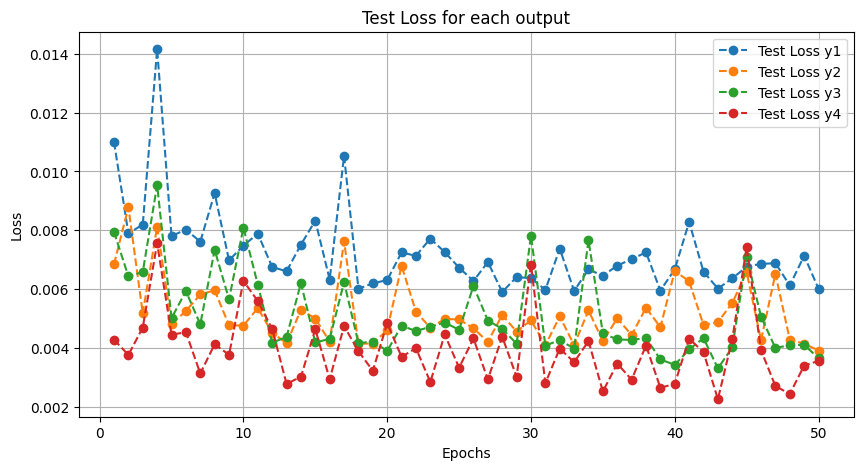

In [35]:
# Plot showing testing loss for each individual output
plt.figure(figsize=(10, 5))
for key in ["y1", "y2", "y3", "y4"]:
    plt.plot(range(1, epochs+1), test_losses[key], label=f"Test Loss {key}", marker="o", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Loss for each output")
plt.legend()
plt.grid()
plt.show()

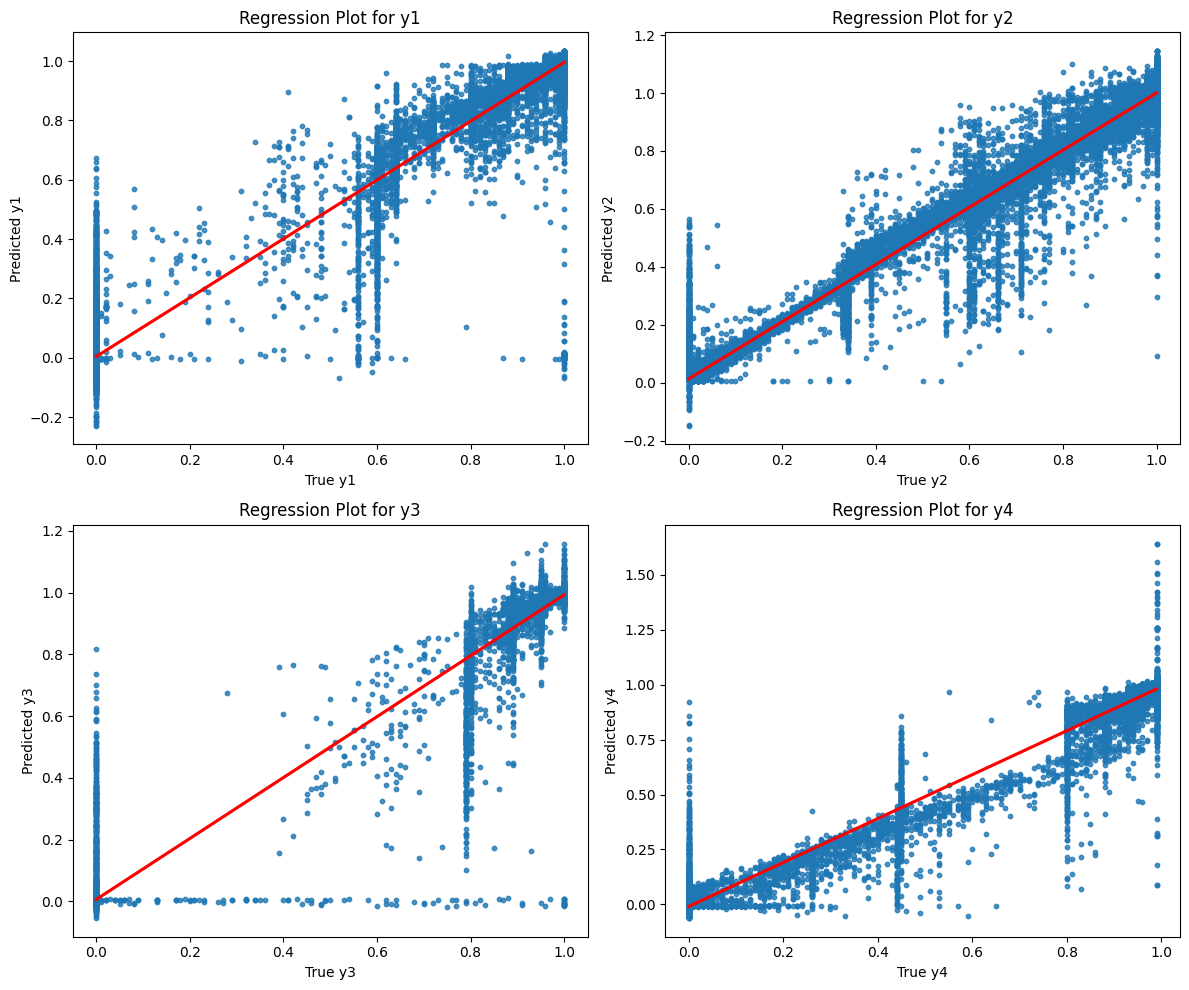

In [36]:
## Regression line between predictions and true labels.

labels = ["y1", "y2", "y3", "y4"]

plt.figure(figsize=(12, 10))
for i, label in enumerate(labels):
    plt.subplot(2, 2, i+1)
    sns.regplot(x=y_test[:, i], y=y_pred_test[:, i], scatter_kws={"s": 10}, line_kws={"color": "red"})
    plt.xlabel(f"True {label}")
    plt.ylabel(f"Predicted {label}")
    plt.title(f"Regression Plot for {label}")

plt.tight_layout()
plt.show()